In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')

plt.rc(
    "figure",
    figsize=(12,8),
    autolayout = True
)

plt.rc(
    "axes",
    labelsize=16,
    labelweight ='bold',
    titlesize=18,
    titleweight = 'bold',
    titlepad = 10
)
plot_params = dict(
    color = '0.75',
    style = ".-",
    markeredgecolor = '0.25',
    markerfacecolor = '0.25',
    legend = False
)

%config InlineBackend.figure_format = 'retina'

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


data = pd.read_csv('data/tunnel.csv',
                    parse_dates = ['Day'])

data = data.set_index('Day').to_period('D')
data.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


<AxesSubplot:title={'center':'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='NumVehicles'>

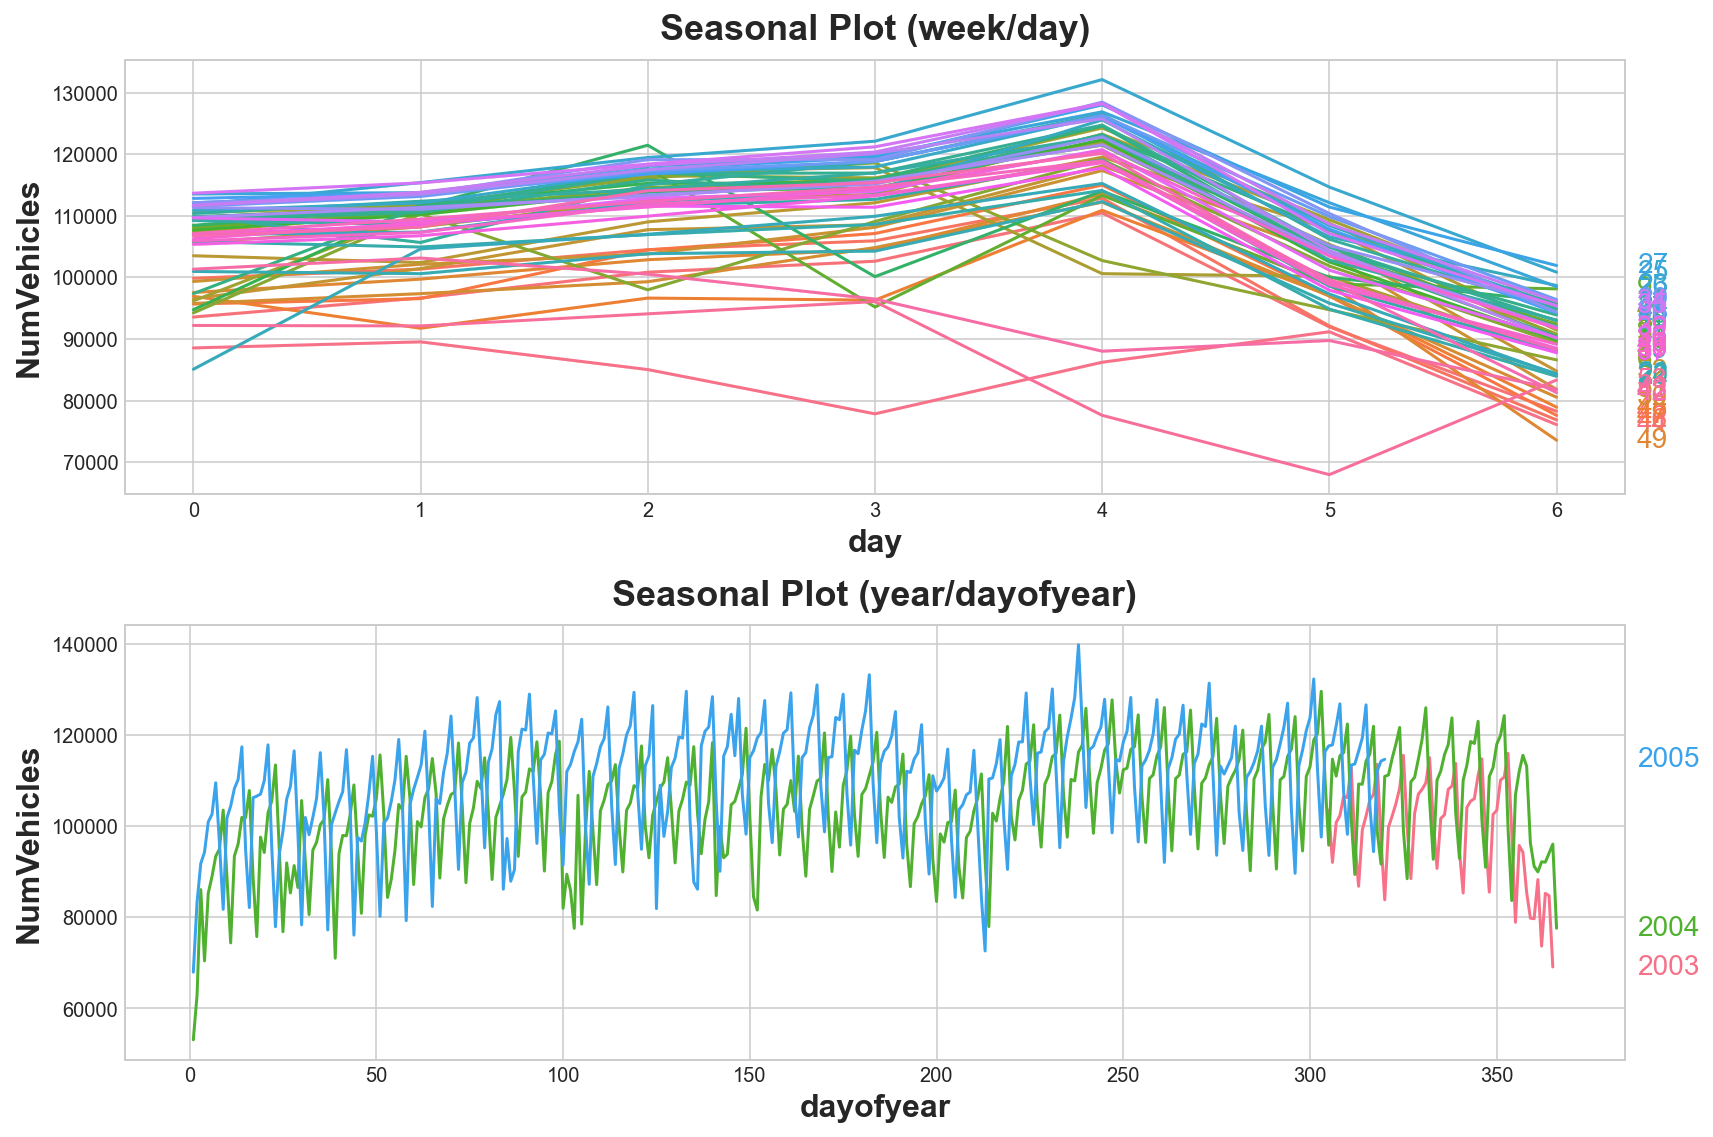

In [7]:
X = data.copy()

X['day'] = X.index.dayofweek
X['week'] = X.index.week

X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

fig, (ax0, ax1) = plt.subplots(
                        nrows =2,
                        ncols = 1,
                        figsize=(12,8)
                                )

seasonal_plot(X, y = 'NumVehicles', period = 'week', freq='day', ax = ax0)
seasonal_plot(X, y = 'NumVehicles', period = 'year', freq = 'dayofyear', ax = ax1)

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

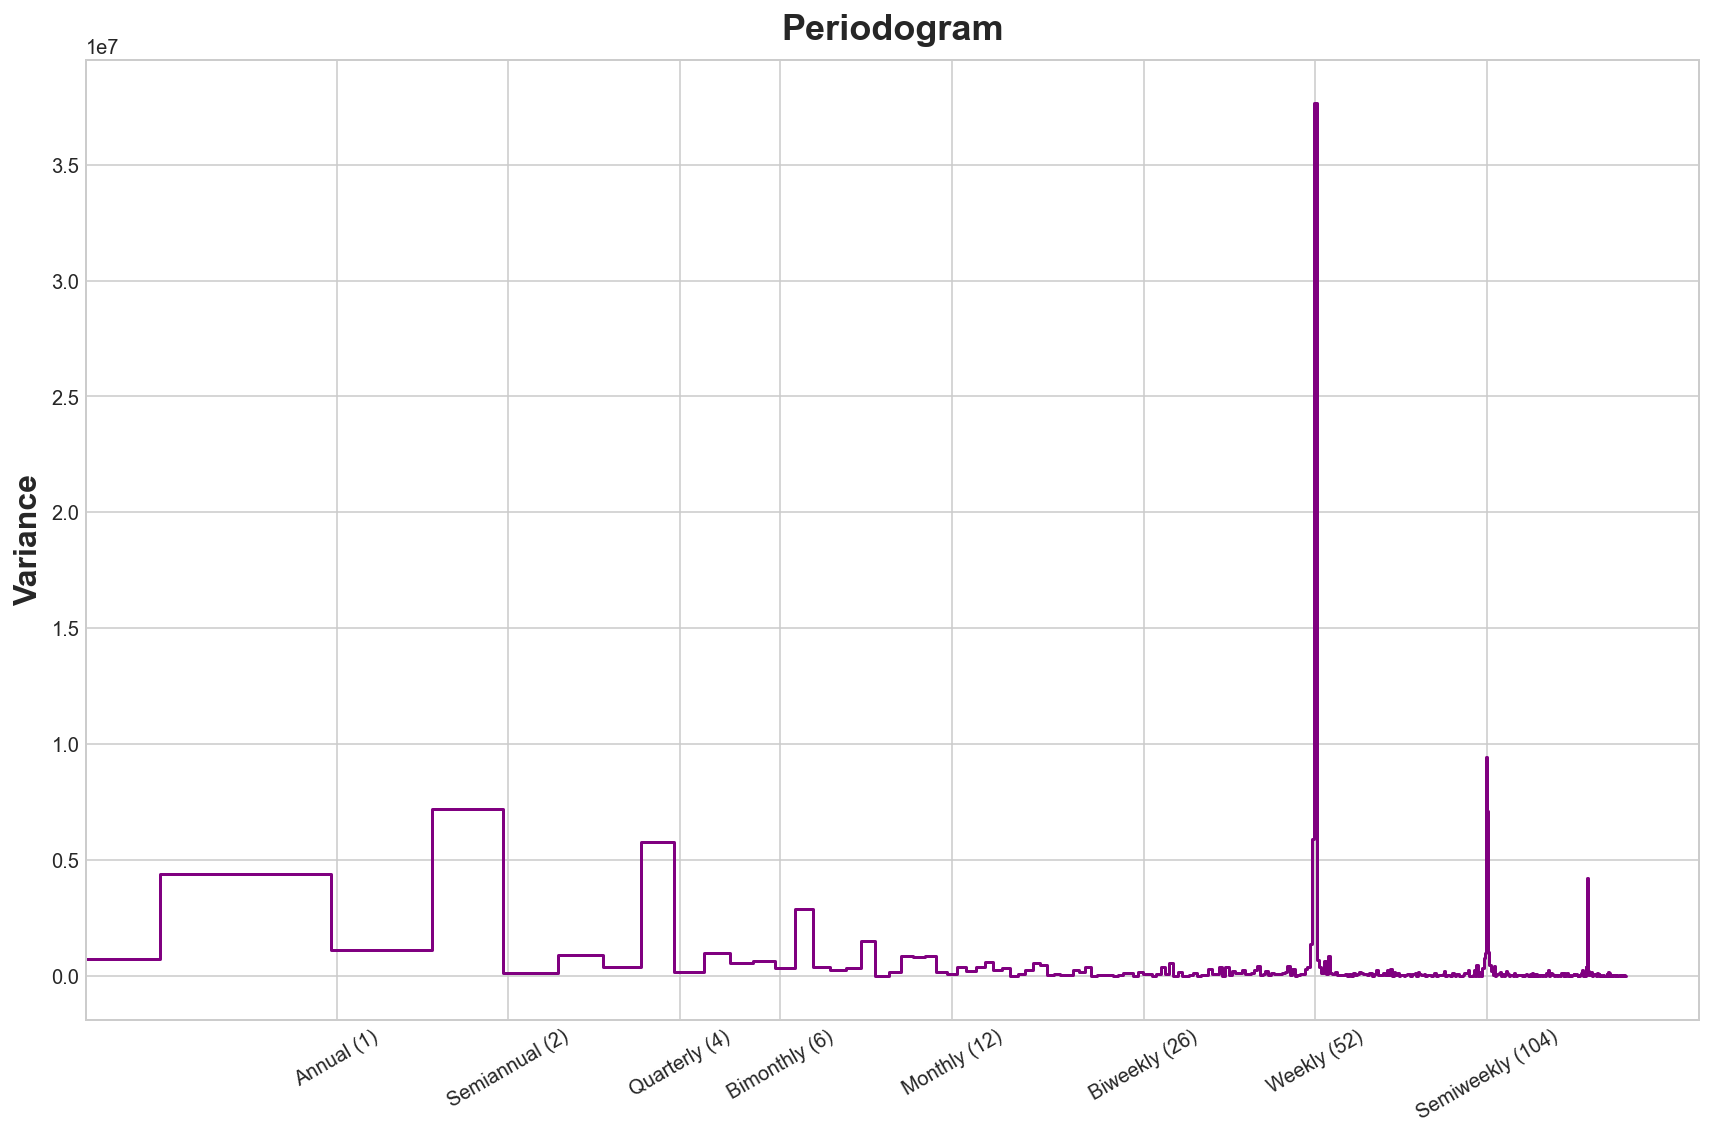

In [8]:
plot_periodogram(data.NumVehicles)

In [9]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

Fourier = CalendarFourier(freq = 'A', order = 10)

dp = DeterministicProcess(
    index = data.index,
    constant = True,
    drop = True,
    order = 1,
    additional_terms = [Fourier],
    seasonal = True
)

X = dp.in_sample()

In [10]:
y = data['NumVehicles']

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X,y)

LinearRegression()

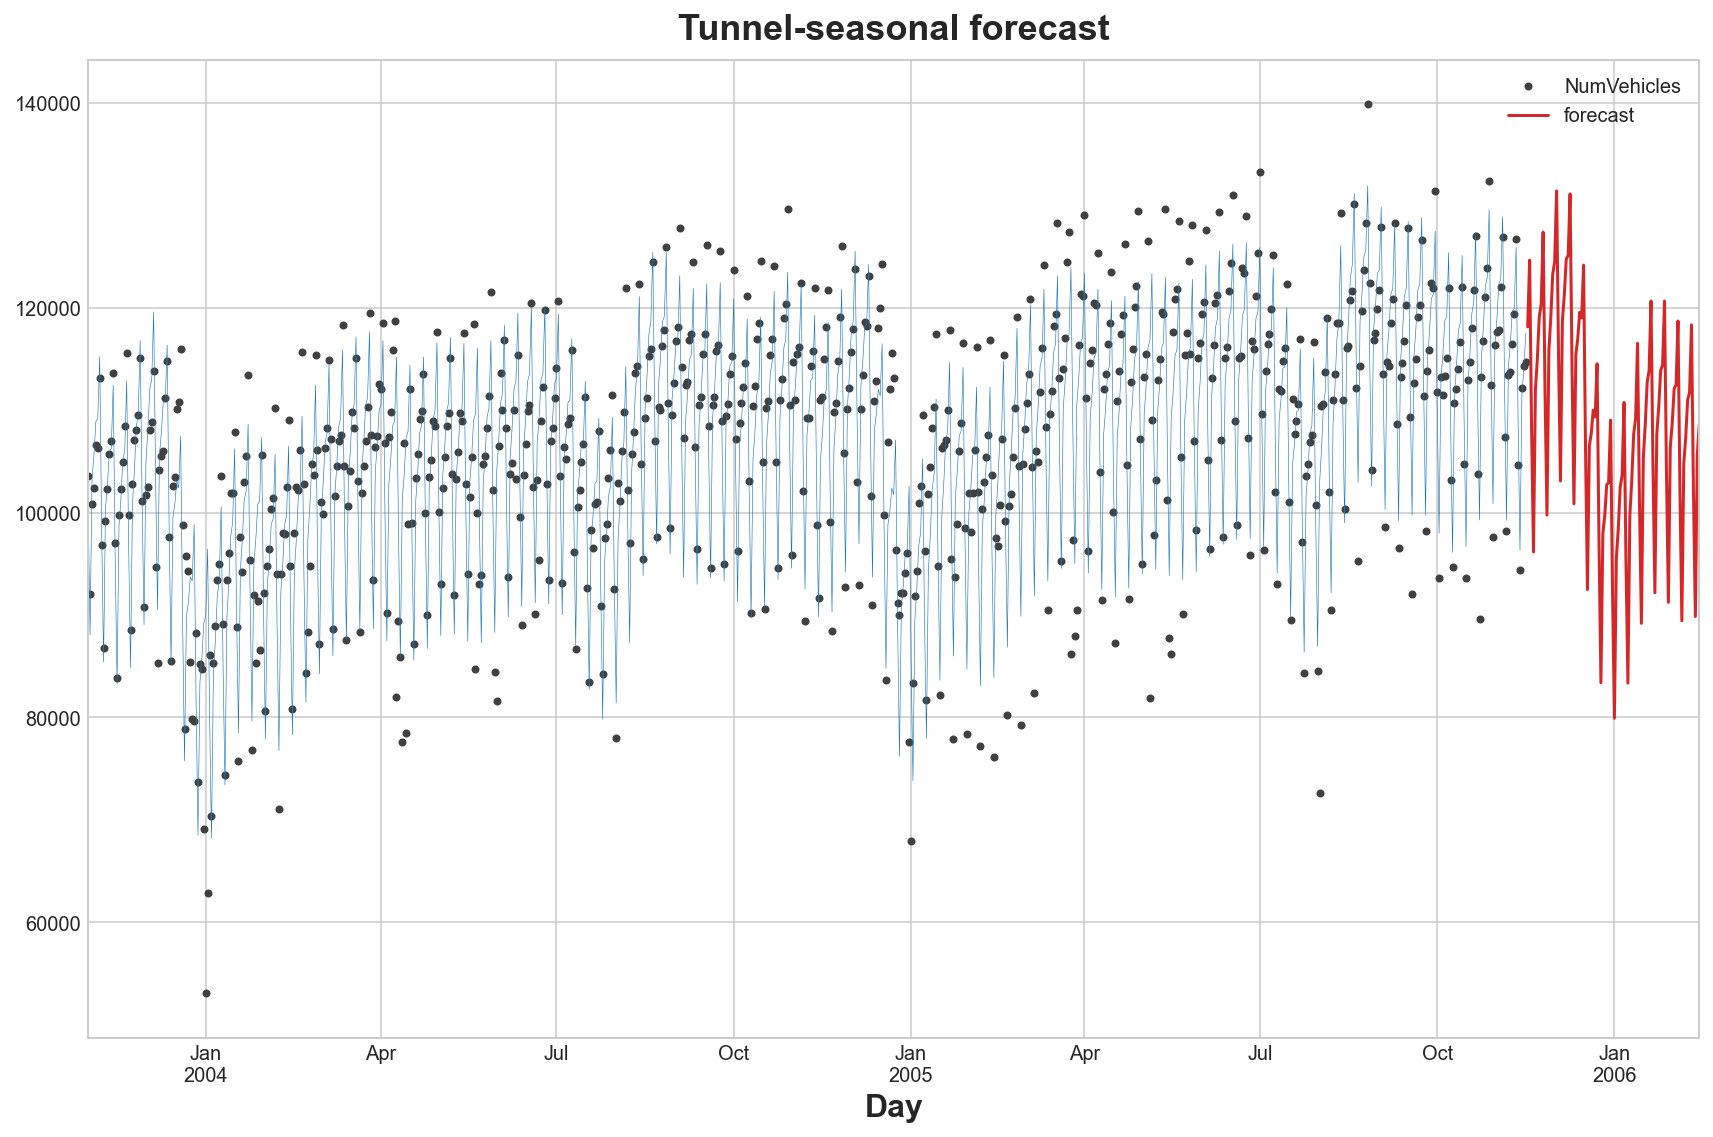

In [11]:
y_pred = pd.Series(model.predict(X), index = y.index)

X_fore = dp.out_of_sample(steps = 90)
y_fore = pd.Series(model.predict(X_fore), index = X_fore.index)

ax = data.plot(color = '0.25', style ='.', title="Tunnel-seasonal forecast")
ax = y_pred.plot(ax = ax, label = 'seasonal', linewidth = 0.3)
ax = y_fore.plot(ax = ax, label = 'forecast', color = 'C3', legend = True)
plt.show()